In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.enable_eager_execution()
import os
import time
import numpy as np
import io
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)



Using TensorFlow backend.


# Training data preprocessing

In [97]:

data_train = "shakespeare_train.txt"

with io.open(data_train , 'r' , encoding= 'utf8') as f :
    text = f.read()
print(len(text))
# Character collection
vocab = sorted(set(text))
idx2char = np.array(vocab)

# Construct character dictionary
vocab_to_int = {c:i for i , c in enumerate( vocab )}
int_to_vocab = dict (enumerate(vocab))

# Encode data , shape = [number of characters]
train_data = np.array([vocab_to_int[c]for c in text] , dtype=np.int32)

4351312


In [4]:
print('{')
for char,_ in zip(vocab_to_int, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), vocab_to_int[char]))
print('  ...\n}')

print ('{} unique characters'.format(len(vocab)))

print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), train_data[:13]))

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}
67 unique characters
'First Citizen' ---- characters mapped to int ---- > [18 49 58 59 60  1 15 49 60 49 66 45 54]


In [5]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(train_data)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
dataset

<DatasetV1Adapter shapes: ((100,), (100,)), types: (tf.int32, tf.int32)>

# Validation data preprocessing

In [6]:
valid_data =  "shakespeare_valid.txt"

with io.open(valid_data , 'r' , encoding= 'utf8') as f :
    valid_text = f.read()

valid_vocab = sorted(set(text))
valid_idx2char = np.array(vocab)

valid_vocab_to_int = {c:i for i , c in enumerate( vocab )}
valid_int_to_vocab = dict (enumerate(vocab))

valid_data = np.array([valid_vocab_to_int[c]for c in valid_text] , dtype=np.int32)

In [7]:
print ('{} ---- characters mapped to int ---- > {}'.format(repr(valid_text[:13]), valid_data[:13]))

'DUKE ORSINO:\n' ---- characters mapped to int ---- > [16 33 23 17  1 27 30 31 21 26 27 10  0]


In [8]:
valid_seq_length = 100
examples_per_epoch = len(valid_text)//(valid_seq_length+1)

valid_char_dataset = tf.data.Dataset.from_tensor_slices(valid_data)
valid_sequences = valid_char_dataset.batch(valid_seq_length+1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

validation_dataset = valid_sequences.map(split_input_target)
validation_dataset

<DatasetV1Adapter shapes: ((100,), (100,)), types: (tf.int32, tf.int32)>

In [9]:
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
print(validation_dataset)

<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>
<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>


# Training Model

In [10]:
vocab_size = len(vocab)

embedding_dim = 256

rnn_units = 1024

In [11]:
vocab_size

67

In [12]:
from keras.regularizers import l2
L2 = 0
L2_rnn = 0
def build_model_rnn(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[batch_size, None]),
    tf.keras.layers.SimpleRNN(rnn_units,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'),
                      
    tf.keras.layers.Dense(vocab_size)])
    return model

def build_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim,batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,return_sequences=True,stateful=True,recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)])
    return model

model_rnn = build_model_rnn(vocab_size = len(vocab), embedding_dim=embedding_dim,rnn_units=rnn_units,batch_size=BATCH_SIZE)
model_lstm = build_model_lstm(vocab_size = len(vocab), embedding_dim=embedding_dim,rnn_units=rnn_units,batch_size=BATCH_SIZE)
model_rnn.summary()
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           17152     
_________________________________________________________________
simple_rnn (SimpleRNN)       (64, None, 1024)          1311744   
_________________________________________________________________
dense (Dense)                (64, None, 67)            68675     
Total params: 1,397,571
Trainable params: 1,397,571
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (64, None, 256)           17152     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
________________________

In [12]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model_lstm(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 67) # (batch_size, sequence_length, vocab_size)


In [13]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [14]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 "but I shall turn his jest to sorrow.\nI was the chief that raised him to the crown,\nAnd I'll be chief"

Next Char Predictions: 
 'C[N]LLiAlueOKGn HQvMx&i,N[[jyXOVupel.ZU;CEf\nAAeFXlYQqG?fKMHmldXTMcT$!IZc[NtjG r-nW[?K Y-,ZVSR!-,3OC.'


In [15]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

model_rnn.compile(optimizer='nadam', loss=loss, metrics=['sparse_categorical_accuracy'])
model_lstm.compile(optimizer='nadam', loss=loss, metrics=['sparse_categorical_accuracy'])

Prediction shape:  (64, 100, 67)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.2042623


In [0]:
checkpoint_dir = 'RNN_1024_100'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

checkpoint_dir_lstm = 'LSTM_1024_100'
checkpoint_prefix_lstm = os.path.join(checkpoint_dir_lstm, "ckpt_{epoch}")

checkpoint_callback_lstm=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix_lstm,
    save_weights_only=True)

callbacks_lstm =[checkpoint_callback_lstm]
callbacks_rnn =[checkpoint_callback]
EPOCHS=20

In [0]:
history = model_rnn.fit(dataset, epochs=EPOCHS, callbacks=callbacks_rnn,validation_data=(validation_dataset))

Epoch 1/20
673/673 [==============================] - 59s 87ms/step - loss: 2.1365 - sparse_categorical_accuracy: 0.3928 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/20
673/673 [==============================] - 56s 83ms/step - loss: 1.6199 - sparse_categorical_accuracy: 0.5186 - val_loss: 1.6304 - val_sparse_categorical_accuracy: 0.5147
Epoch 3/20
475/673 [====================>.........] - ETA: 16s - loss: 1.4996 - sparse_categorical_accuracy: 0.5488

In [0]:

history_lstm = model_lstm.fit(dataset, epochs=EPOCHS, callbacks=callbacks_lstm,validation_data=(validation_dataset))

Epoch 1/20
673/673 [==============================] - 141s 209ms/step - loss: 1.9940 - sparse_categorical_accuracy: 0.4257 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 0.0000e+00
Epoch 2/20
673/673 [==============================] - 139s 207ms/step - loss: 1.4465 - sparse_categorical_accuracy: 0.5631 - val_loss: 1.4826 - val_sparse_categorical_accuracy: 0.5527
Epoch 3/20
673/673 [==============================] - 140s 208ms/step - loss: 1.3355 - sparse_categorical_accuracy: 0.5906 - val_loss: 1.4405 - val_sparse_categorical_accuracy: 0.5637
Epoch 4/20
673/673 [==============================] - 141s 209ms/step - loss: 1.2779 - sparse_categorical_accuracy: 0.6054 - val_loss: 1.4272 - val_sparse_categorical_accuracy: 0.5693
Epoch 5/20
673/673 [==============================] - 141s 209ms/step - loss: 1.2348 - sparse_categorical_accuracy: 0.6169 - val_loss: 1.4274 - val_sparse_categorical_accuracy: 0.5700
Epoch 6/20
673/673 [==============================] - 140s 209ms/step - 

# Plotting Learning Results

Save learning history

In [ ]:
with open('/content/gdrive/My Drive/Colab Notebooks/training_checkpoints/history_LSTM/train1024_100', 'wb') as file_lstm:
      pickle.dump(history_lstm.history, file_lstm)

with open('/content/gdrive/My Drive/Colab Notebooks/training_checkpoints/history_RNN/train1024_100', 'wb') as file_rnn:
      pickle.dump(history.history, file_rnn)      

In [60]:
rnn_history = pickle.load(open("training_checkpoints/history_RNN/train1024_100", "rb" ))
lstm_history = pickle.load(open("training_checkpoints/history_LSTM/train1024_100", "rb" ))

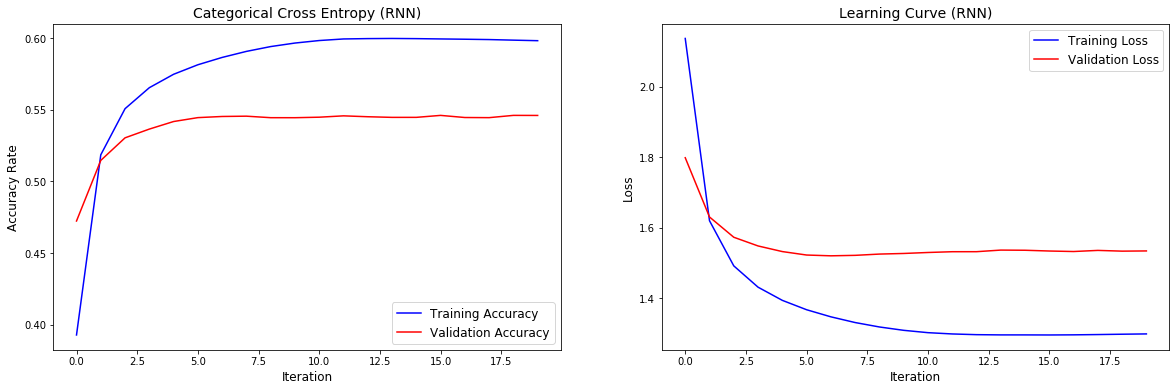

In [58]:

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(rnn_history['sparse_categorical_accuracy'], 'b',rnn_history['val_sparse_categorical_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy (RNN)',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(rnn_history['loss'], 'b',rnn_history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve (RNN)',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

plt.savefig('rnn_curve.png')
plt.show()
# files.download("acc.png") 

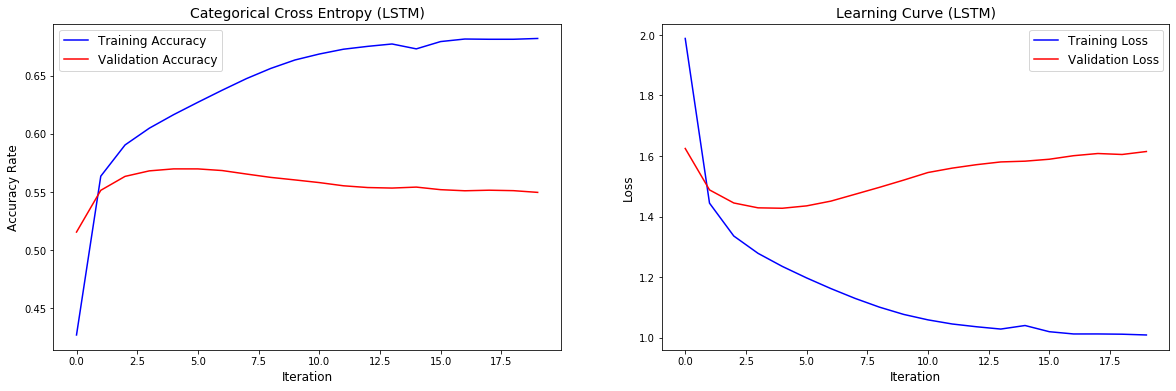

In [60]:
fig, ((ax3, ax4)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax3.plot(lstm_history['sparse_categorical_accuracy'], 'b',lstm_history['val_sparse_categorical_accuracy'], 'r')
ax3.set_ylabel('Accuracy Rate',fontsize=12)
ax3.set_xlabel('Iteration',fontsize=12)
ax3.set_title('Categorical Cross Entropy (LSTM)',fontsize=14)
ax3.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax4.plot(lstm_history['loss'], 'b', lstm_history['val_loss'],'r')
ax4.set_ylabel('Loss',fontsize=12)
ax4.set_xlabel('Iteration',fontsize=12)
ax4.set_title('Learning Curve (LSTM)',fontsize=14)
ax4.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

plt.savefig('lstm_curve.png')
plt.show()


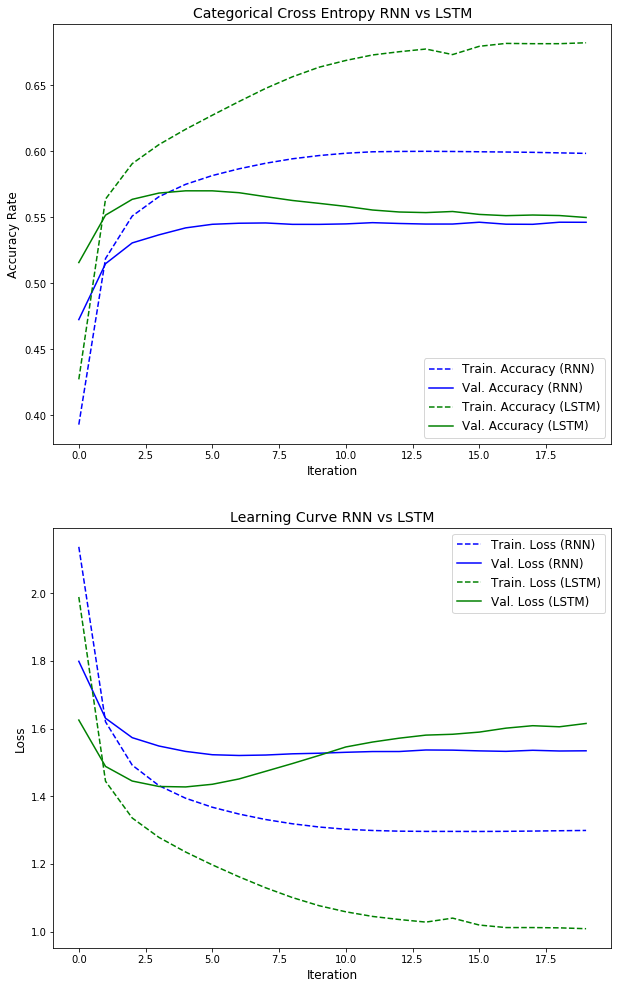

In [76]:

fig, ((ax1),(ax2)) = plt.subplots(nrows=2, ncols=1,figsize=(10,17))
ax1.plot(rnn_history['sparse_categorical_accuracy'], 'b--',rnn_history['val_sparse_categorical_accuracy'], 'b',
        lstm_history['sparse_categorical_accuracy'], 'g--',lstm_history['val_sparse_categorical_accuracy'], 'g')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy RNN vs LSTM',fontsize=14)
ax1.legend(['Train. Accuracy (RNN)','Val. Accuracy (RNN)','Train. Accuracy (LSTM)','Val. Accuracy (LSTM)'],fontsize=12,loc='best')

ax2.plot(rnn_history['loss'], 'b--',rnn_history['val_loss'],'b',
        lstm_history['loss'], 'g--', lstm_history['val_loss'],'g')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve RNN vs LSTM',fontsize=14)
ax2.legend(['Train. Loss (RNN)','Val. Loss (RNN)','Train. Loss (LSTM)','Val. Loss (LSTM)'],fontsize=12,loc='best')


plt.savefig('lstm_rnn_comparison.png')
plt.show()

# Generate Words 

In [18]:
def generate_checkpoint(model,checkpoint):

    if (model == 'lstm'):
        model = build_model_lstm(vocab_size, embedding_dim, rnn_units, batch_size=1)
        model_dir = 'training_checkpoints/LSTM_1024_100/ckpt_'+ str(checkpoint)
        model.load_weights(model_dir)
        model.build(tf.TensorShape([1, None]))
        return model

    if (model =='rnn'):
        model = build_model_rnn(vocab_size, embedding_dim, rnn_units, batch_size=1)
        model_dir = 'training_checkpoints/RNN_1024_100/ckpt_'+ str(checkpoint)
        model.load_weights(model_dir)
        model.build(tf.TensorShape([1, None]))
        return model
    
def generate_text(model, start_string):
        
    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [vocab_to_int[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])
    # model.summary()
    return (start_string + ''.join(text_generated))


In [96]:
model = generate_checkpoint('rnn',20)
print(generate_text(model, start_string="Q"))

QUOMPHY:
Camell too:
If not the door thou would be understand,
As sure tires wars, that would be
warrant
The subtrey of him and marching a where, musters, else writ as toold prove itself and save him off.
Then proved him of unto usiner means.

OTHELLO:
Ah, forsworn
Thy fall down to by-
Often pittle time, leave us like: you show a honey-work,
He prisoners,
In living boy.
So thy shard,
And I a shave it could be come thy tongue Servants:
What rights, one minished,
Till French carcelets shame, you ho


# Learning Curve VS Different Parameter

In [78]:
rnn_history_1024_100 = pickle.load(open("training_checkpoints/history_RNN/train1024_100", "rb" ))
rnn_history_1024_50 = pickle.load(open("training_checkpoints/history_RNN/train1024_50", "rb" ))
rnn_history_512_100 = pickle.load(open("training_checkpoints/history_RNN/train512_100", "rb" ))
rnn_history_512_50 = pickle.load(open("training_checkpoints/history_RNN/train512_50", "rb" ))
lstm_history_1024_100 = pickle.load(open("training_checkpoints/history_LSTM/train1024_100", "rb" ))
lstm_history_1024_50 = pickle.load(open("training_checkpoints/history_LSTM/train1024_50", "rb" ))
lstm_history_512_100 = pickle.load(open("training_checkpoints/history_LSTM/train512_100", "rb" ))
lstm_history_512_50 = pickle.load(open("training_checkpoints/history_LSTM/train512_50", "rb" ))

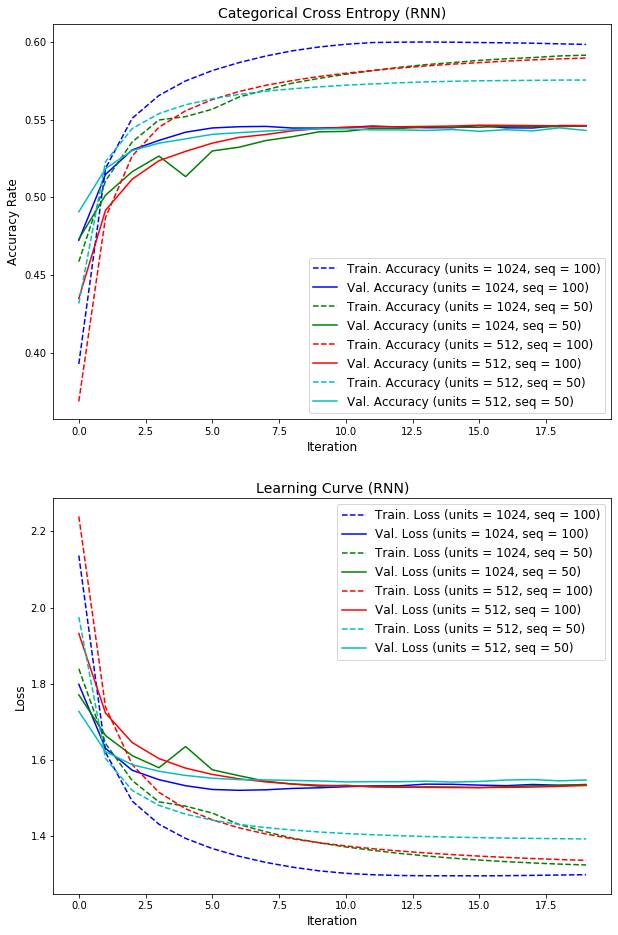

In [80]:
fig, ((ax1), (ax2)) = plt.subplots(nrows=2, ncols=1,figsize=(10,16))

ax1.plot(rnn_history_1024_100['sparse_categorical_accuracy'], 'b--',rnn_history_1024_100['val_sparse_categorical_accuracy'], 'b'
        ,rnn_history_1024_50['sparse_categorical_accuracy'], 'g--',rnn_history_1024_50['val_sparse_categorical_accuracy'], 'g'
        ,rnn_history_512_100['sparse_categorical_accuracy'], 'r--',rnn_history_512_100['val_sparse_categorical_accuracy'], 'r'
        ,rnn_history_512_50['sparse_categorical_accuracy'], 'c--',rnn_history_512_50['val_sparse_categorical_accuracy'], 'c')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy (RNN)',fontsize=14)
ax1.legend(['Train. Accuracy (units = 1024, seq = 100)','Val. Accuracy (units = 1024, seq = 100)'
            ,'Train. Accuracy (units = 1024, seq = 50)','Val. Accuracy (units = 1024, seq = 50)'
            ,'Train. Accuracy (units = 512, seq = 100)','Val. Accuracy (units = 512, seq = 100)'
            ,'Train. Accuracy (units = 512, seq = 50)','Val. Accuracy (units = 512, seq = 50)'],fontsize=12,loc='best')

ax2.plot(rnn_history_1024_100['loss'], 'b--',rnn_history_1024_100['val_loss'],'b'
        ,rnn_history_1024_50['loss'], 'g--',rnn_history_1024_50['val_loss'],'g'
        ,rnn_history_512_100['loss'], 'r--',rnn_history_512_100['val_loss'],'r'
        ,rnn_history_512_50['loss'], 'c--',rnn_history_512_50['val_loss'],'c')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve (RNN)',fontsize=14)
ax2.legend(['Train. Loss (units = 1024, seq = 100)','Val. Loss (units = 1024, seq = 100)'
            ,'Train. Loss (units = 1024, seq = 50)','Val. Loss (units = 1024, seq = 50)'
            ,'Train. Loss (units = 512, seq = 100)','Val. Loss (units = 512, seq = 100)'
            ,'Train. Loss (units = 512, seq = 50)','Val. Loss (units = 512, seq = 50)'],fontsize=12,loc='best')

plt.savefig('parameter_rnn.png')
plt.show()

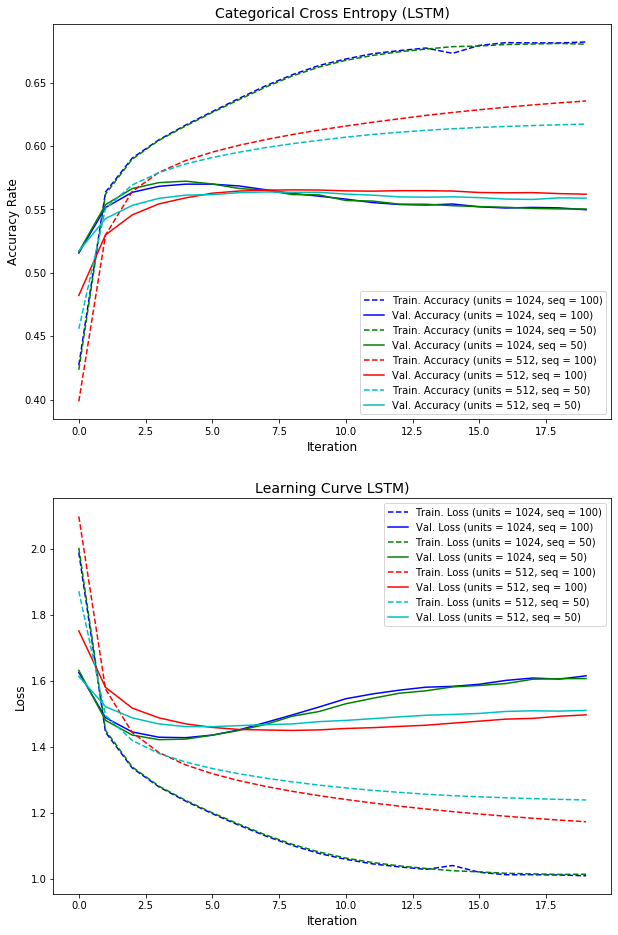

In [81]:
fig, ((ax1), (ax2)) = plt.subplots(nrows=2, ncols=1,figsize=(10,16))
ax1.plot(lstm_history_1024_100['sparse_categorical_accuracy'], 'b--',lstm_history_1024_100['val_sparse_categorical_accuracy'], 'b'
        ,lstm_history_1024_50['sparse_categorical_accuracy'], 'g--',lstm_history_1024_50['val_sparse_categorical_accuracy'], 'g'
        ,lstm_history_512_100['sparse_categorical_accuracy'], 'r--',lstm_history_512_100['val_sparse_categorical_accuracy'], 'r'
        ,lstm_history_512_50['sparse_categorical_accuracy'], 'c--',lstm_history_512_50['val_sparse_categorical_accuracy'], 'c')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Categorical Cross Entropy (LSTM)',fontsize=14)
ax1.legend(['Train. Accuracy (units = 1024, seq = 100)','Val. Accuracy (units = 1024, seq = 100)'
            ,'Train. Accuracy (units = 1024, seq = 50)','Val. Accuracy (units = 1024, seq = 50)'
            ,'Train. Accuracy (units = 512, seq = 100)','Val. Accuracy (units = 512, seq = 100)'
            ,'Train. Accuracy (units = 512, seq = 50)','Val. Accuracy (units = 512, seq = 50)'],fontsize=10,loc='best')

ax2.plot(lstm_history_1024_100['loss'], 'b--',lstm_history_1024_100['val_loss'],'b'
        ,lstm_history_1024_50['loss'], 'g--',lstm_history_1024_50['val_loss'],'g'
        ,lstm_history_512_100['loss'], 'r--',lstm_history_512_100['val_loss'],'r'
        ,lstm_history_512_50['loss'], 'c--',lstm_history_512_50['val_loss'],'c')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve LSTM)',fontsize=14)
ax2.legend(['Train. Loss (units = 1024, seq = 100)','Val. Loss (units = 1024, seq = 100)'
            ,'Train. Loss (units = 1024, seq = 50)','Val. Loss (units = 1024, seq = 50)'
            ,'Train. Loss (units = 512, seq = 100)','Val. Loss (units = 512, seq = 100)'
            ,'Train. Loss (units = 512, seq = 50)','Val. Loss (units = 512, seq = 50)'],fontsize=10,loc='best')

plt.savefig('parameter_lstm.png')
plt.show()